In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
file = '0.npy'
item_with_index = np.load(file, allow_pickle=True)
item = item_with_index[0].astype(np.float16)
max_len = 2537
def add_padding(max_frames, item):
    current_length = item.shape[0]
    if current_length < max_frames:
        padding = np.full(
            (max_frames - current_length, 2172), 
            -1,
            dtype=np.float16
        )
        padding[:, 3::4] = 0
        item = np.concatenate((item, padding), axis=0)
    return item
matrix = add_padding(max_len, item)
print(matrix.shape)

(2537, 2172)


In [3]:
# Paso 1: Generar la matriz y centrar los datos restando la media de cada columna
matrix_meaned = matrix - np.mean(matrix, axis=0)

# Paso 2: Calcular la matriz de covarianza
cov_matrix = np.cov(matrix_meaned, rowvar=False)

# Paso 3: Calcular los valores y vectores propios
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Paso 4: Filtrar valores propios negativos o muy cercanos a cero
eigenvalues = eigenvalues[eigenvalues > 1e-10]  # Filtramos los valores muy pequeños o negativos

# Ordenar los valores propios en orden descendente
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

In [4]:
sorted_eigenvalues

array([5.19550005e+02, 2.39021131e+00, 1.81370447e+00, 1.53915371e-01,
       1.33642882e-01, 1.26072599e-01, 7.53240331e-02, 6.85276694e-02,
       6.29602555e-02, 5.26533923e-02, 5.05396203e-02, 3.76370129e-02,
       3.32244687e-02, 2.71920772e-02, 2.38341974e-02, 2.06183004e-02,
       2.05274334e-02, 1.93943570e-02, 1.81752928e-02, 1.59502268e-02,
       1.47500680e-02, 1.41385407e-02, 1.35532487e-02, 1.25477156e-02,
       1.16610045e-02, 1.11583573e-02, 1.07492825e-02, 9.71044812e-03,
       8.90326107e-03, 8.29467154e-03, 7.63800702e-03, 7.27892053e-03,
       6.54521194e-03, 6.40881126e-03, 5.75400981e-03, 5.31309477e-03,
       5.04231847e-03, 4.62615894e-03, 4.51009199e-03, 4.08080042e-03,
       3.88037589e-03, 3.49789812e-03, 3.42522135e-03, 3.14828901e-03,
       2.92962024e-03, 2.83373799e-03, 2.50288766e-03, 2.41876158e-03,
       2.26887231e-03, 2.13060324e-03, 2.01402426e-03, 1.91487459e-03,
       1.82726782e-03, 1.77590303e-03, 1.61926374e-03, 1.57560551e-03,
      

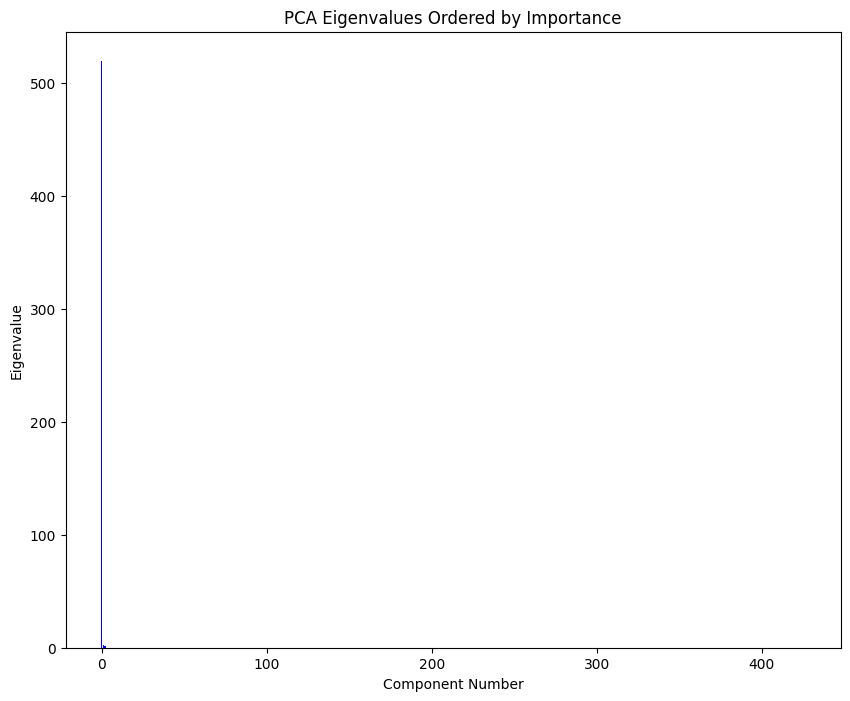

In [5]:
# Paso 5: Graficar los valores propios en un gráfico de barras verticales (bar)
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_eigenvalues)), sorted_eigenvalues, color='blue')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('PCA Eigenvalues Ordered by Importance')

plt.show()

In [6]:
pc = PCA()
pc.fit(matrix)

PCA()

[9.89746489e-01 4.55292347e-03 3.45483212e-03 ... 6.38533444e-34
 3.55085168e-34 1.44978527e-34]


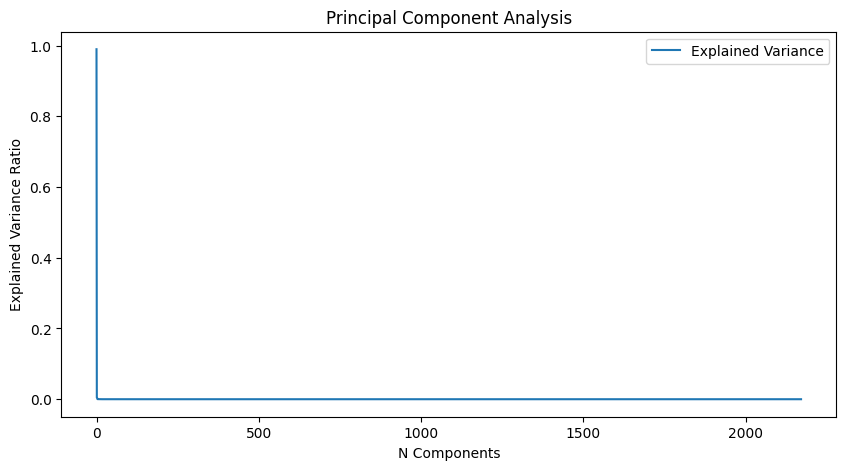

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Principal Component Analysis')
plt.plot(pc.explained_variance_ratio_)
print(pc.explained_variance_ratio_)
plt.legend(['Explained Variance'])
plt.xlabel('N Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [9]:
pc = PCA(n_components=1)
new_matrix = pc.fit_transform(matrix)
print("Original matrix shape:", matrix.shape)
print("New matrix shape after PCA:", new_matrix.shape)

Original matrix shape: (2537, 2172)
New matrix shape after PCA: (2537, 1)


[0.98974649]


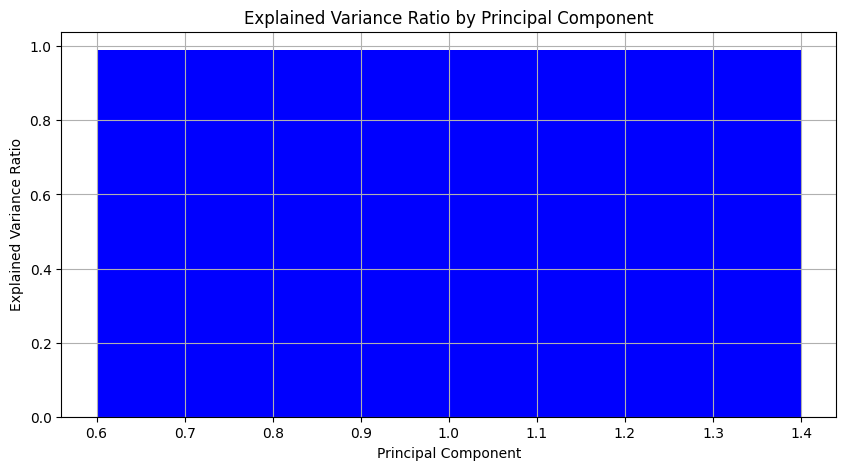

In [10]:
# Paso 2: Graficar la varianza explicada por cada componente principal
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pc.explained_variance_ratio_) + 1), pc.explained_variance_ratio_, color='blue')
print(pc.explained_variance_ratio_)
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [28]:
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from transformers import AutoModel
bert = AutoModel.from_pretrained('bert-base-uncased')
vocab_size = 30000

# Definir la arquitectura BERT con la reducción PCA incluida
class BERT_Arch(nn.Module):
    def __init__(self, bert, vocab_size):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        self.pca = PCA(n_components=1)
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=3, padding=0)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # ReLU activation function
        self.relu = nn.ReLU()

        # Dense layer 1
        self.fc1 = nn.Linear(512, 512)
        
        # Dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, vocab_size)

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, seq_input: torch.Tensor, mask: torch.Tensor):
        new_seq_input = []
        print(seq_input.shape)
        for i in range(seq_input.shape[0]):
            print(seq_input[i].shape)
            a = self.pca.fit_transform(seq_input[i])
            print(a.shape)
            a = torch.tensor(a, dtype=torch.float32)
            a = self.conv1d(a)
            print(a.shape)
            new_seq_input.append(a)
        new_seq_input = torch.stack(new_seq_input)
        print(new_seq_input.shape)
        outputs = self.bert(inputs_embeds=new_seq_input, attention_mask=mask, return_dict=True)

        # Usar el último estado oculto
        x = outputs.last_hidden_state
        
        # Pasar por capas densas
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Aplicar softmax
        x = self.softmax(x)

        return x

# Inicializar el modelo con BERT y vocab_size
model = BERT_Arch(bert, vocab_size)

# Definir el optimizador y la función de pérdida
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
cross_entropy = nn.CrossEntropyLoss()

# Número de épocas de entrenamiento
epochs = 10

c:\Users\matia\OneDrive\Escritorio\SignAI-ML\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
mask = torch.ones(matrix.shape)
print(mask.shape)
matrix = np.array([matrix])
print(matrix.shape)
mask = np.array([mask])
print(mask.shape)

torch.Size([2537, 2172])


In [29]:
output = model(matrix, mask)

(1, 2537, 2172)
(2537, 2172)
(2537, 1)


RuntimeError: Given groups=1, weight of size [512, 1, 3], expected input[1, 2537, 1] to have 1 channels, but got 2537 channels instead